<a href="https://colab.research.google.com/github/meleeshagamage/CourseWork_ML/blob/main/ML_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK 1

In [200]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.tree import plot_tree
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report



print("Libraries loaded")

Libraries loaded


In [173]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [174]:
#Import the dataset
df = pd.read_csv('/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [175]:
#Get the shape
print("Shape:", df.shape)
df.info()

Shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

In [176]:
## Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [177]:
#Count Missing Values
print("Missing values after cleaning:")
print(df.isnull().sum())

Missing values after cleaning:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


### EDA visualizations


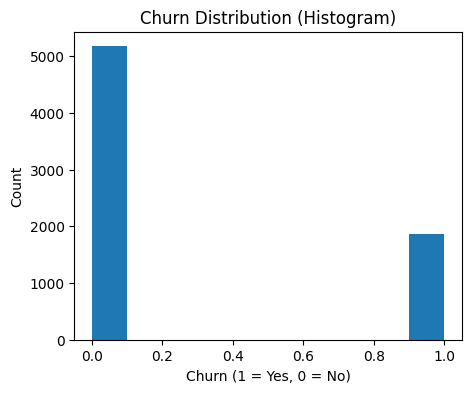

In [178]:
df['Churn_numeric'] = df['Churn'].map({'Yes':1, 'No':0})

plt.figure(figsize=(5,4))
plt.hist(df['Churn_numeric'])
plt.title('Churn Distribution (Histogram)')
plt.xlabel('Churn (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()



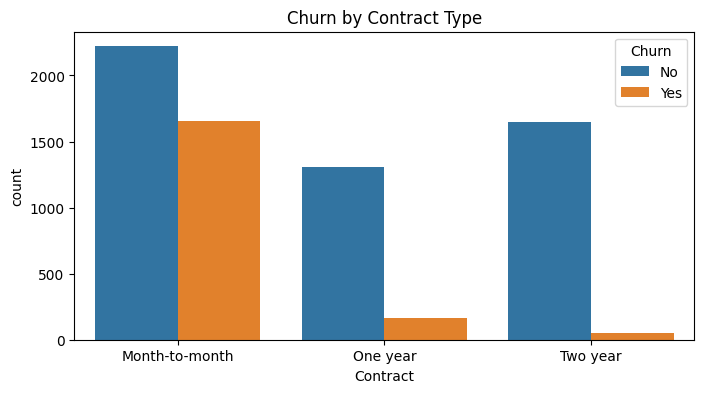

In [179]:
# Churn rate by Contract type
plt.figure(figsize=(8,4))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.show()


Numeric cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_numeric']


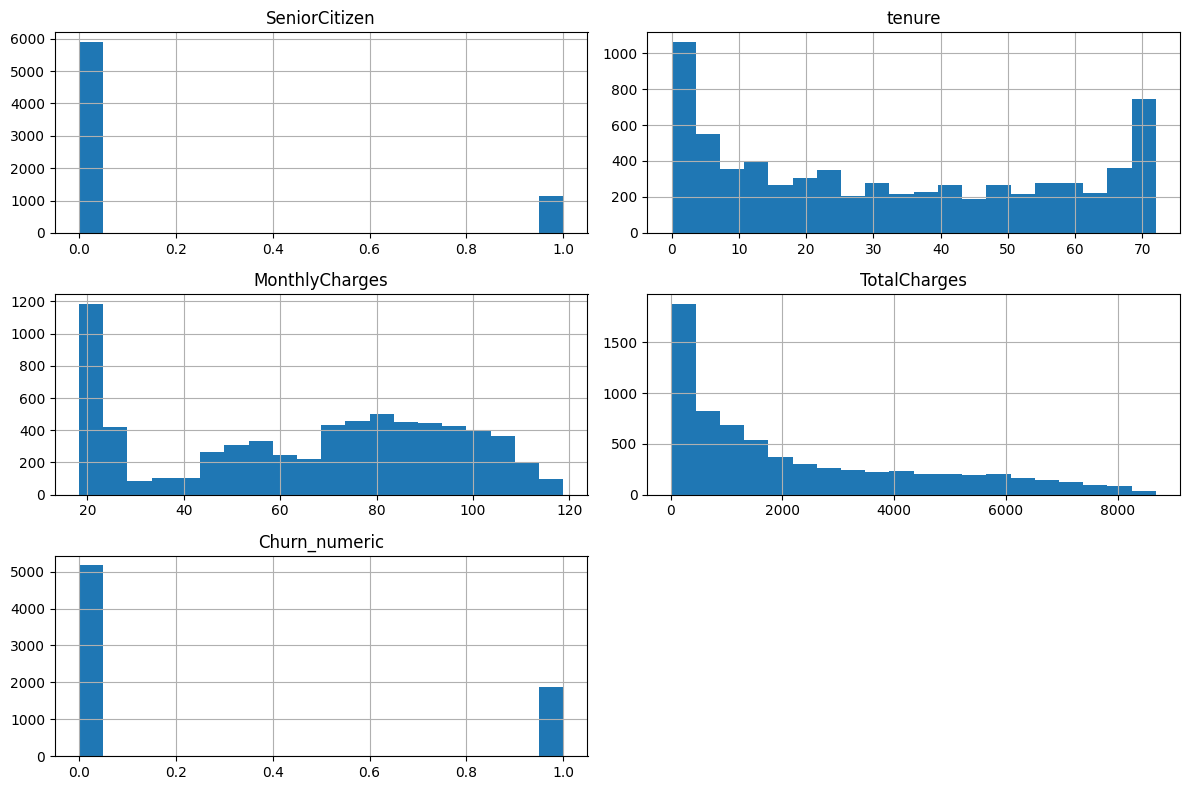

In [180]:
# Numeric columns histograms
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
print("Numeric cols:", num_cols)
df[num_cols].hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()

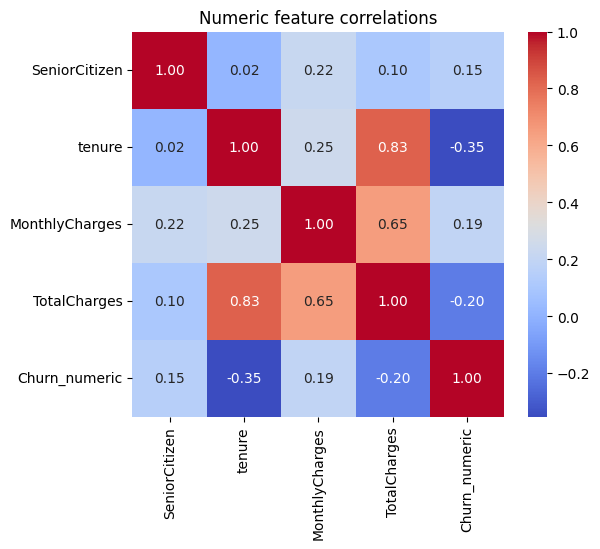

In [181]:
# Correlation heatmap among numeric features
plt.figure(figsize=(6,5))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Numeric feature correlations')
plt.show()

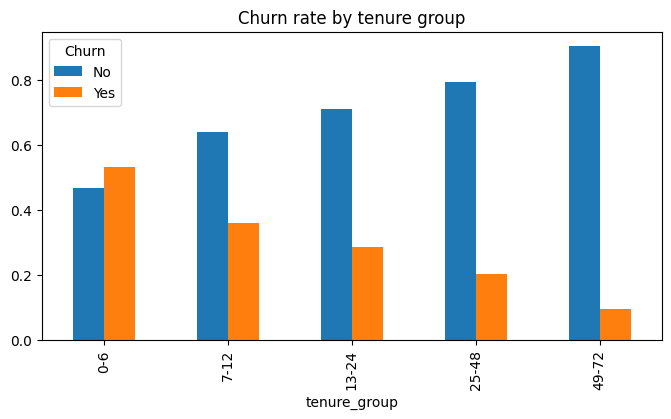

In [182]:
# Churn rate by tenure buckets
df['tenure_group'] = pd.cut(df['tenure'], bins=[0,6,12,24,48,72], labels=['0-6','7-12','13-24','25-48','49-72'])
churn_by_tenure = df.groupby('tenure_group')['Churn'].value_counts(normalize=True).unstack()
churn_by_tenure.plot(kind='bar', stacked=False, figsize=(8,4))
plt.title('Churn rate by tenure group')
plt.show()

### Train-test split

In [183]:
# Make sure you're using the NUMERIC version for modeling
y = df['Churn_numeric']

# Drop both Churn columns from features
X = df.drop(['Churn', 'Churn_numeric'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [184]:
# After spliting the data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (5634, 21)
X_test shape: (1409, 21)
y_train shape: (5634,)
y_test shape: (1409,)


In [185]:
# Check class distribution is maintained
print(f"Original churn ratio: {df['Churn'].value_counts(normalize=True)}")
print(f"Train churn ratio: {y_train.value_counts(normalize=True)}")
print(f"Test churn ratio: {y_test.value_counts(normalize=True)}")

Original churn ratio: Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64
Train churn ratio: Churn_numeric
0    0.734647
1    0.265353
Name: proportion, dtype: float64
Test churn ratio: Churn_numeric
0    0.734564
1    0.265436
Name: proportion, dtype: float64


### Preprocessing & feature engineering

In [186]:
# Fill missing TotalCharges
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [187]:
# Encode target
df['Churn'] = df['Churn'].map({'Yes':1,'No':0})

In [188]:
# Identify categorical and numeric cols from the feature set X
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns

print("Numeric features for preprocessing:", numeric_features)
print("Categorical features for preprocessing:", categorical_features)

Numeric features for preprocessing: Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')
Categorical features for preprocessing: Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [189]:
if 'Churn' in cat_cols:
    cat_cols.remove('Churn')

if 'Churn' in num_cols:
    num_cols.remove('Churn')

In [190]:
# For simplicity, drop 'tenure_group' if created earlier (we'll use tenure numeric and will remove the tenure_group we creared for the visualization task)
if 'tenure_group' in df.columns:
    df = df.drop(columns=['tenure_group'])

In [191]:
# Remove customerID column because it can mislead the model
df = df.drop(columns=['customerID'])


In [192]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# TASK 2

### Decision Tree with hyperparameter tuning

In [193]:
dt_pipeline = Pipeline(steps=[
    ("preproc", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42))
])

In [194]:
param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [3, 5, 8, 12, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__class_weight': [None, 'balanced']   # handle imbalance
}

grid_dt = GridSearchCV(
    dt_pipeline,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)


grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot...
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__class_weight': [None, 'balanced'],
                         'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [3, 5, 8, 12, None],
                         'clf__min_samples_leaf': [1, 2, 4],
                         'clf__min_samples_split': [2, 5, 10]},
             scoring='f1', verbose=1)

In [195]:
print("Best Decision Tree parameters:")
print(grid_dt.best_params_)
print("\nBest CV F1-score (training CV):")
print(grid_dt.best_score_)

Best Decision Tree parameters:
{'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}

Best CV F1-score (training CV):
0.6204258562219814


In [196]:
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]


In [197]:
print("\n===== TEST RESULTS (UNPRUNED DT) =====")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1:", f1_score(y_test, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_test, y_proba_dt))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_dt))


===== TEST RESULTS (UNPRUNED DT) =====
Accuracy: 0.7459190915542938
Precision: 0.5140350877192983
Recall: 0.7834224598930482
F1: 0.6207627118644068
ROC AUC: 0.8144126688883723

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.75      0.76      1409



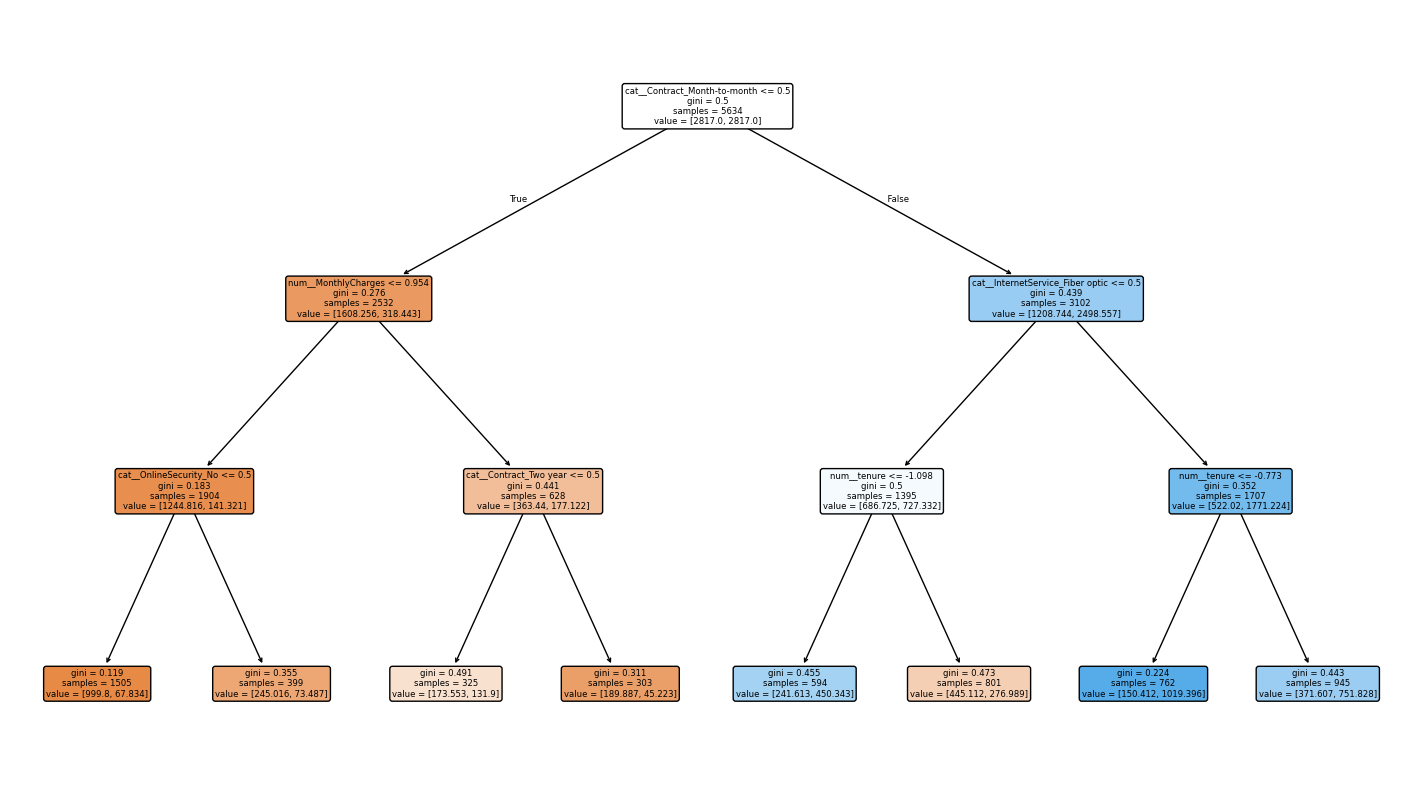

In [201]:
feature_names = best_dt.named_steps["preproc"].get_feature_names_out()

plt.figure(figsize=(18,10))
plot_tree(
    best_dt.named_steps["clf"],
    feature_names=feature_names,
    filled=True,
    rounded=True,
    max_depth=3
)
plt.show()


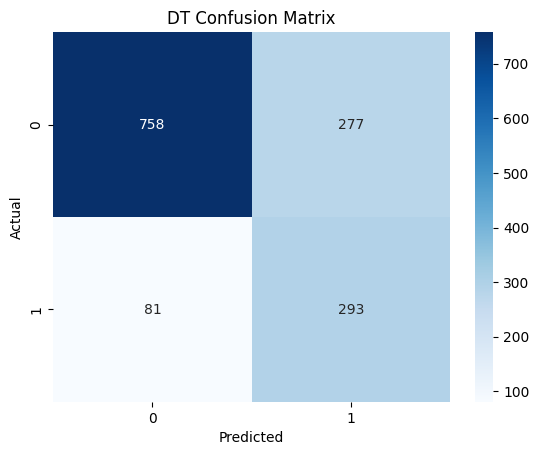

In [207]:
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('DT Confusion Matrix')
plt.show()

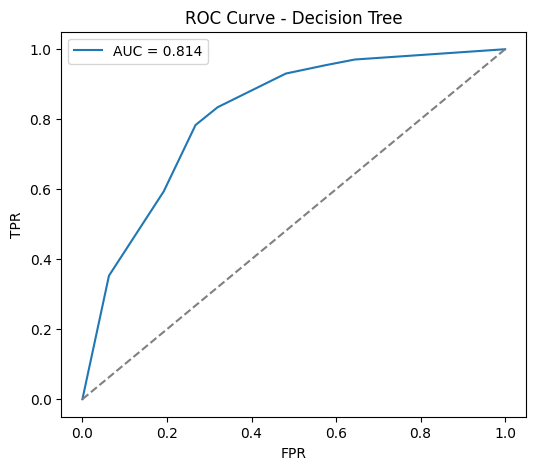

In [208]:
fpr, tpr, _ = roc_curve(y_test, y_proba_dt)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.title("ROC Curve - Decision Tree")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()


In [209]:
# Pruning

# Extract preprocessed training & test data from the pipeline
X_train_pp = best_dt.named_steps['preproc'].transform(X_train)
X_test_pp  = best_dt.named_steps['preproc'].transform(X_test)

# Extract the raw decision tree classifier
clf_unpruned = best_dt.named_steps['clf']


In [210]:
path = clf_unpruned.cost_complexity_pruning_path(X_train_pp, y_train)
ccp_alphas = path.ccp_alphas


In [211]:
clfs = []
for alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha, class_weight=best_dt.named_steps['clf'].class_weight)
    model.fit(X_train_pp, y_train)
    clfs.append(model)

# Evaluate each model on test set
test_scores = [model.score(X_test_pp, y_test) for model in clfs]

best_index = test_scores.index(max(test_scores))
best_alpha = ccp_alphas[best_index]
print("\nBest alpha for pruning:", best_alpha)


Best alpha for pruning: 0.0


In [212]:
pruned_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_dt.fit(X_train_pp, y_train)


DecisionTreeClassifier(ccp_alpha=np.float64(0.0), random_state=42)

In [213]:
y_pred_pruned = pruned_dt.predict(X_test_pp)

print("Pruned Decision Tree Performance:")
print(classification_report(y_test, y_pred_pruned))


Pruned Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.59      0.50      0.54       374

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.69      1409
weighted avg       0.76      0.77      0.77      1409



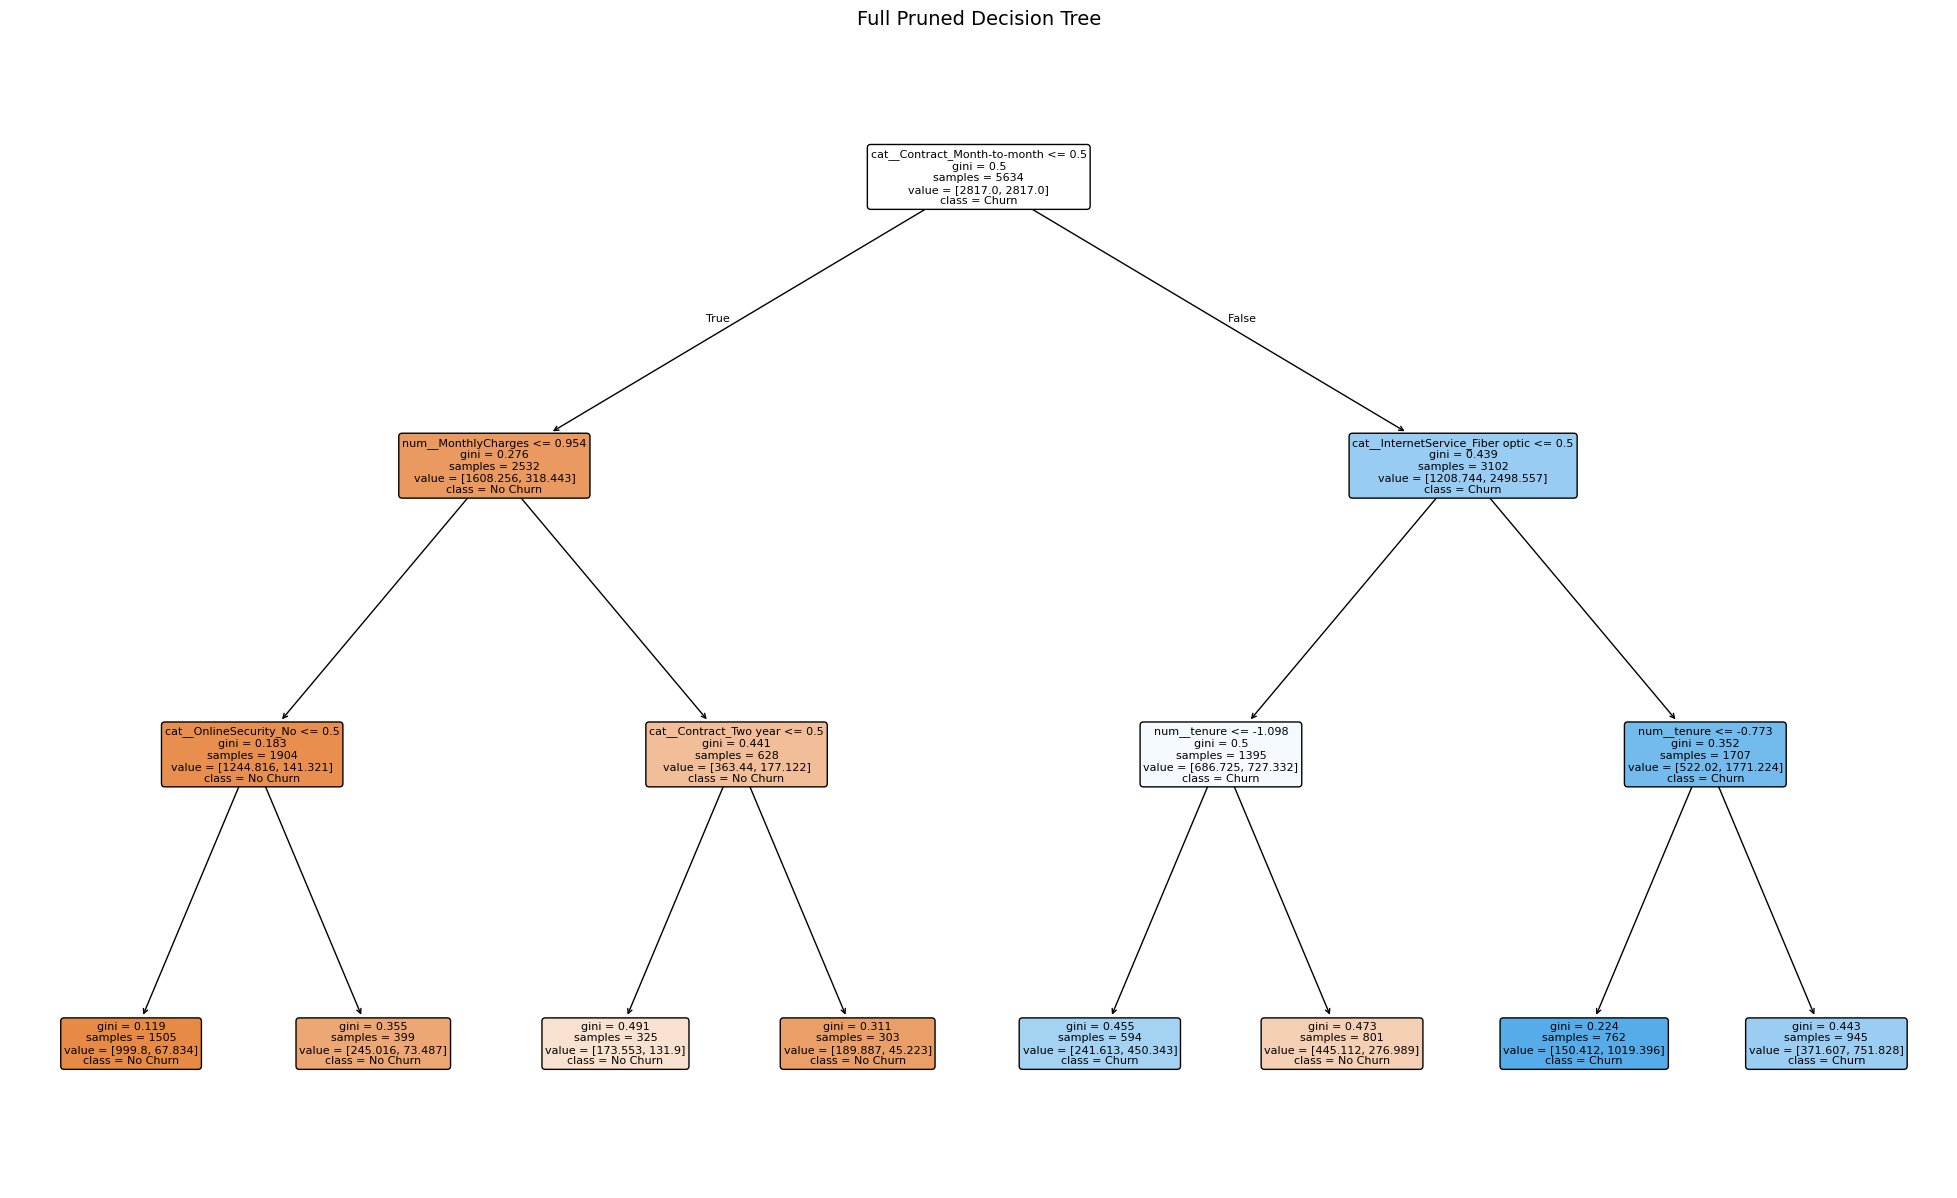

In [215]:
plt.figure(figsize=(25, 15))
plot_tree(
    best_dt.named_steps["clf"],
    feature_names=feature_names,
    class_names=['No Churn', 'Churn'],
    filled=True,
    rounded=True,
    fontsize=8  # Smaller font to fit everything
)
plt.title("Full Pruned Decision Tree", fontsize=14)
plt.show()

### Neural Network

In [216]:
# Preprocess data using  existing preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

# Convert sparse → dense
X_train_np = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_test_np  = X_test_processed.toarray()  if hasattr(X_test_processed, "toarray")  else X_test_processed

y_train_np = y_train.values
y_test_np  = y_test.values

input_dim = X_train_np.shape[1]
print("Input dimension for ANN:", input_dim)


Input dimension for ANN: 5679


In [217]:
def build_and_train_nn(units, layers_count, dropout, epochs=30, batch_size=64):
    model = Sequential()

    # Input layer + first hidden
    model.add(Dense(units, activation="relu", input_dim=input_dim))
    if dropout > 0:
        model.add(Dropout(dropout))

    # Additional hidden layers
    for i in range(layers_count - 1):
        model.add(Dense(units, activation="relu"))
        if dropout > 0:
            model.add(Dropout(dropout))

    # Output layer
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    model.fit(
        X_train_np, y_train_np,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    # Evaluate
    y_pred_prob = model.predict(X_test_np).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)
    acc = accuracy_score(y_test_np, y_pred)

    return model, acc


In [218]:
tuning_results = []

for units in [32, 64]:
    for layers_count in [1, 2]:
        for dropout in [0.0, 0.3]:
            model, acc = build_and_train_nn(units, layers_count, dropout)
            tuning_results.append({
                'units': units,
                'layers': layers_count,
                'dropout': dropout,
                'accuracy': acc
            })
            print(f"units={units}, layers={layers_count}, dropout={dropout} → accuracy={acc:.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
units=32, layers=1, dropout=0.0 → accuracy=0.8006
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
units=32, layers=1, dropout=0.3 → accuracy=0.7977
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
units=32, layers=2, dropout=0.0 → accuracy=0.7921
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
units=32, layers=2, dropout=0.3 → accuracy=0.7956
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
units=64, layers=1, dropout=0.0 → accuracy=0.7991
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
units=64, layers=1, dropout=0.3 → accuracy=0.7999
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
units=64, layers=2, dropout=0.0 → accuracy=0.7850
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
units=64, layers=2, dropout=0.3 → accuracy=0.7999


In [219]:
best_config = max(tuning_results, key=lambda x: x['accuracy'])
best_config


{'units': 32, 'layers': 1, 'dropout': 0.0, 'accuracy': 0.8005677785663591}

In [220]:
best_units = best_config['units']
best_layers = best_config['layers']
best_dropout = best_config['dropout']

print("Training final ANN with:", best_config)

final_model, _ = build_and_train_nn(
    units=best_units,
    layers_count=best_layers,
    dropout=best_dropout,
    epochs=60,
    batch_size=32
)


Training final ANN with: {'units': 32, 'layers': 1, 'dropout': 0.0, 'accuracy': 0.8005677785663591}
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


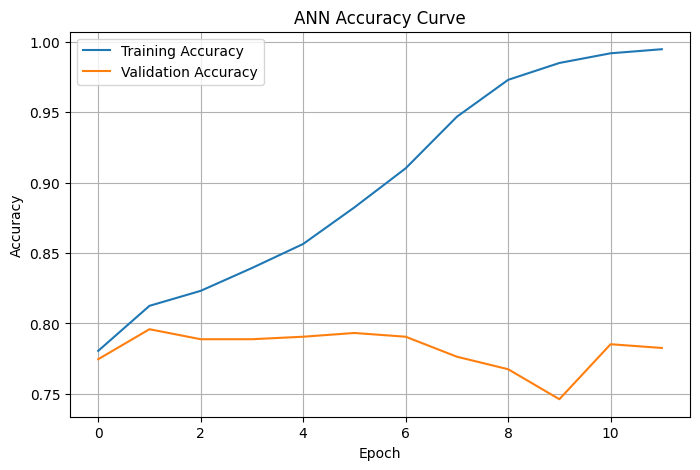

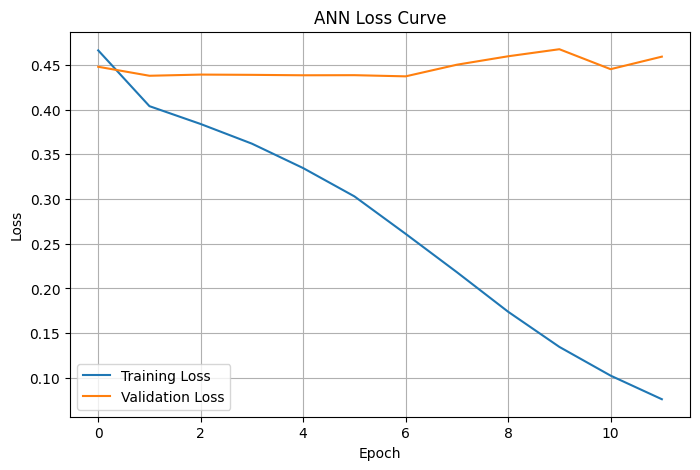

In [221]:
history = final_model.history  # saved from training


# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("ANN Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("ANN Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [222]:

y_pred_prob = final_model.predict(X_test_np).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Final ANN Evaluation:")
print("Accuracy:", accuracy_score(y_test_np, y_pred))
print("Precision:", precision_score(y_test_np, y_pred))
print("Recall:", recall_score(y_test_np, y_pred))
print("F1 Score:", f1_score(y_test_np, y_pred))
print("ROC-AUC:", roc_auc_score(y_test_np, y_pred_prob))
print("\nClassification Report:\n")
print(classification_report(y_test_np, y_pred))


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Final ANN Evaluation:
Accuracy: 0.7934705464868701
Precision: 0.6334405144694534
Recall: 0.5267379679144385
F1 Score: 0.5751824817518248
ROC-AUC: 0.8374977395437754

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.53      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



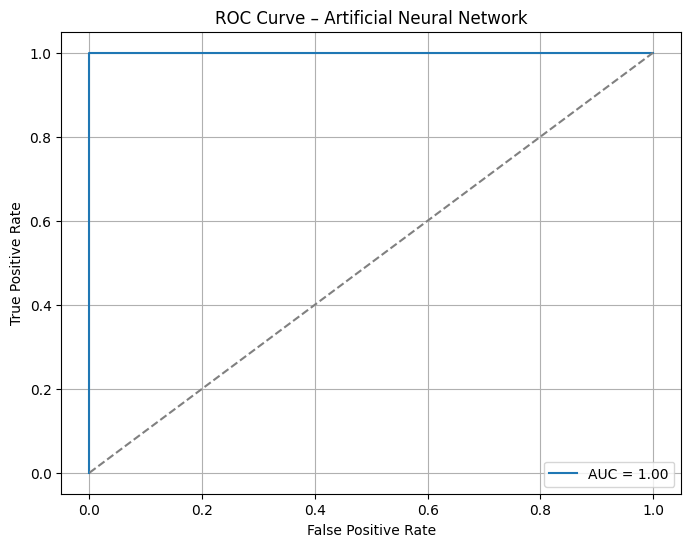

In [ ]:
fpr, tpr, _ = roc_curve(y_test_np, y_pred_prob)
roc_value = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_value:.2f}")
plt.plot([0,1],[0,1],'--',color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Artificial Neural Network")
plt.legend()
plt.grid(True)
plt.show()
